In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import StandardScaler
import torch.nn.functional as F
from torch.nn.parallel import DataParallel
from torch.cuda.amp import autocast, GradScaler
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler

if torch.cuda.is_available():
    device = torch.device("cuda")
    print(device)
else:
    device = torch.device("cpu")
    print("GPU 不可用，将在 CPU 上运行")

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:32"
torch.cuda.empty_cache()  # 释放显存

# 定义标准化函数
def normalize_row(row):
    data = row.dropna()
    mean = np.mean(data)
    std = np.std(data)
    row[row.notna()] = (row[row.notna()] - mean) / std
    return row

cuda


In [4]:

#因子正交
class MyModelZJ(nn.Module):
    def __init__(self, input_size,num_factors, num_stocks):
        super(MyModelZJ, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
               
        # 定义全连接层
        self.fc = nn.Linear(input_size, num_factors)  #
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #

    def forward(self, x):
        batch_size, _, num_features = x.size()
        x = x.view(-1, num_features)
        # 全连接层
        fc_out = self.fc(x)
        fc_out=fc_out.view(batch_size*self.num_stocks,self.num_factors)
        factor_output = self.bn(fc_out)
        factor_output = factor_output.view(batch_size, self.num_stocks, self.num_factors)
        return factor_output


In [18]:

#多因子预测
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks,preday):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        self.preday=preday
        
        # 定义LSTM层
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2,batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        print(x.shape)
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        print(x.shape)
        # LSTM层
        lstm_out, _ = self.lstm(x)
        print('lstmout',lstm_out.shape)
        # 最后10个时间步的输出
        lstm_out = lstm_out[:, -self.preday:, :]
        print('最后时间步',lstm_out.shape)
        # 全连接层
        fc_out = self.fc(lstm_out)
        print('全连接层',fc_out.shape)
        # 批标准化层
        fc_out=fc_out.view(batch_size*self.num_stocks*self.preday,self.num_factors)
        factor_output = self.bn(fc_out)
        print('标准化层',factor_output.shape)
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks,self.preday, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=3)
        print(c.shape)
        return factor_output
model = MyModel(6, 64, 1,0,5, 400,10)
x=torch.rand(4,60,400,6)
y=model(x)

torch.Size([4, 60, 400, 6])
torch.Size([1600, 60, 6])
lstmout torch.Size([1600, 60, 64])
最后时间步 torch.Size([1600, 10, 64])
全连接层 torch.Size([1600, 10, 5])
标准化层 torch.Size([16000, 5])
torch.Size([4, 400, 10])


In [5]:
df21=pd.read_feather('/data/disk4/output_stocks/jmchen/factors/ML/combine21.feather')
index_counts = df21['index'].value_counts()
index_counts=index_counts[index_counts==index_counts.max()]
print(index_counts)
dfx=df21[df21['index'].isin(index_counts.index)]
dfx=dfx.fillna(0)
ds=dfx.groupby('date')

index
1         243
600699    243
600710    243
600708    243
600706    243
         ... 
300123    243
300090    243
300121    243
300120    243
300091    243
Name: count, Length: 4348, dtype: int64


In [4]:
days=index_counts.max()
num_stocks=4348
num_features=4321
X = torch.zeros((days, num_stocks, num_features))
i=0
for day,df in ds:
    print(day)
    df = df.drop(columns=['date'])
    df=df.set_index('index')
    x=torch.Tensor(df.values)
    X[i]=x
    i+=1
    

20210104
20210105
20210106
20210107
20210108
20210111
20210112
20210113
20210114
20210115
20210118
20210119
20210120
20210121
20210122
20210125
20210126
20210127
20210128
20210129
20210201
20210202
20210203
20210204
20210205
20210208
20210209
20210210
20210218
20210219
20210222
20210223
20210224
20210225
20210226
20210301
20210302
20210303
20210304
20210305
20210308
20210309
20210310
20210311
20210312
20210315
20210316
20210317
20210318
20210319
20210322
20210323
20210324
20210325
20210326
20210329
20210330
20210331
20210401
20210402
20210406
20210407
20210408
20210409
20210412
20210413
20210414
20210415
20210416
20210419
20210420
20210421
20210422
20210423
20210426
20210427
20210428
20210429
20210430
20210506
20210507
20210510
20210511
20210512
20210513
20210514
20210517
20210518
20210519
20210520
20210521
20210524
20210525
20210526
20210527
20210528
20210531
20210601
20210602
20210603
20210604
20210607
20210608
20210609
20210610
20210611
20210615
20210616
20210617
20210618
20210621
2

In [5]:
close=pd.read_csv('/data/disk3/DataBase_stocks/AllSample/adjclose.csv',index_col=0)
close.drop([x for x in close.columns if x[-2:]=='BJ'],axis=1,inplace=True)
close.columns=[int(x.split('.')[0]) for x in close.columns]
ret=(close-close.shift(1))/close.shift(1)
ret= ret.fillna(method='bfill')
ret=ret.fillna(0)
ret = ret.apply(normalize_row, axis=1) #标准化
ret1=ret[(ret.index <=20220104) & (ret.index>=20210105)]  #后一天收益率为标签
ret1= ret1[ret1.columns.intersection(index_counts.index)]
Y=torch.Tensor(ret1.values)
Y.shape

torch.Size([243, 4348])

In [6]:
#多因子预测
class MyModel(nn.Module):
    def __init__(self, input_size, hidden_size,num_layers,dropout, num_factors, num_stocks):
        super(MyModel, self).__init__()
        self.num_factors = num_factors
        self.num_stocks = num_stocks
        
        # 定义LSTM层
        #self.lstm = nn.LSTM(input_size, hidden_size, num_layers=2,batch_first=True)
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=num_layers,dropout=dropout,batch_first=True)
        
        # 定义全连接层
        self.fc = nn.Linear(hidden_size, num_factors)  #h
        
        # 定义批标准化层
        self.bn = nn.BatchNorm1d(num_factors)  #z

    def forward(self, x):
        batch_size, T, _, num_features = x.size()
        
        # 将num_stocks维度移到batch_size之后
        x = x.view(-1, T, num_features)
        
        # LSTM层
        lstm_out, _ = self.lstm(x)
        
        # 最后一个时间步的输出
        lstm_out = lstm_out[:, -1, :]
        
        # 全连接层
        fc_out = self.fc(lstm_out)
        
        # 批标准化层
        factor_output = self.bn(fc_out)
        
        # 将结果恢复成(batch_size, num_stocks, num_factors)形状
        factor_output = factor_output.view(batch_size, self.num_stocks, self.num_factors)
        
        # 计算c，这里直接求因子平均
        c = factor_output.mean(dim=2)
        
        return factor_output

In [7]:
def custom_loss_new(y, factor_output):
    c = factor_output.mean(dim=2)  #因子等权求和
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        ct=c[i].T #stocks*preday
        cin=[]
        for j in range(c.shape[2]):
            mean_c = torch.mean(ct[j])
            mean_y = torch.mean(y[i][j])
            
            # Calculate the numerator and denominators for Pearson correlation
            numerator = torch.sum((ct[j] - mean_c) * (y[i][j] - mean_y))
            denominator_c = torch.sqrt(torch.sum((ct[j] - mean_c)**2))
            denominator_y = torch.sqrt(torch.sum((y[i][j] - mean_y)**2))
            
            # Calculate the Pearson correlation coefficient
            pearson_corr = numerator / (denominator_c * denominator_y)
            cin.append(pearson_corr)
        corr.append(torch.stack(cin).mean())
    corr=torch.stack(corr).mean()
    print(corr)
    pen=[]
    for i in range(factor_output.shape[0]): #batch内循环
        penalty=[]
        tt= factor_output[i].transpose(0, 1)
        for j in range(tt.shape[0]): #天数内循环
            correlation_matrix = torch.corrcoef(tt[j].T)
            # 将对角线元素设置为零，即将每列与自身的相关系数剔除
            for i in range(len(correlation_matrix)):
                correlation_matrix[i, i] = 0
            # 计算相关系数的平方和
            zsum = torch.sum(correlation_matrix**2)
            penalty.append(zsum)
        pen.append(torch.stack(penalty).mean())
    pen=torch.stack(pen).mean()
    print(pen)
    loss=-corr+0.1*pen
    return loss

In [6]:
def custom_loss(y, factor_output,k):  #惩罚项系数k
    c = factor_output.mean(dim=2)
    corr=[]
    for i in range(c.shape[0]): #batch内循环
        mean_c = torch.mean(c[i])
        mean_y = torch.mean(y[i])
        
        # Calculate the numerator and denominators for Pearson correlation
        numerator = torch.sum((c[i] - mean_c) * (y[i] - mean_y))
        denominator_c = torch.sqrt(torch.sum((c[i] - mean_c)**2))
        denominator_y = torch.sqrt(torch.sum((y[i] - mean_y)**2))
        # Calculate the Pearson correlation coefficient
        pearson_corr = numerator / (denominator_c * denominator_y)
        corr.append(pearson_corr)
    corr=torch.stack(corr).mean()
    penalty=[]
    for i in range(factor_output.shape[0]): #batch内循环
        correlation_matrix = torch.corrcoef(factor_output[i].T)
        # 将对角线元素设置为零，即将每列与自身的相关系数剔除
        for i in range(factor_output.shape[2]):
            correlation_matrix[i, i] = 0
        # 计算相关系数矩阵的L2范数
        zsum = torch.sum(correlation_matrix**2)
        penalty.append(zsum)
    penalty=torch.stack(penalty).mean().sqrt()
    loss=-corr+k*penalty
    return loss

In [84]:
model = MyModelZJ(4321,500,4088)
x=torch.rand(4,4088,4321)
y=model(x)
label=torch.rand(4,4088)
print(y.shape)
c = y.mean(dim=2)
print(c.shape)
print(custom_loss(label, y,0.1))

torch.Size([4, 4088, 500])
torch.Size([4, 4088])
tensor(1.0806, grad_fn=<AddBackward0>)
tensor(1.0806, grad_fn=<AddBackward0>)


In [60]:
torch.cuda.empty_cache()  # 释放显存
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()
torch.cuda.empty_cache()


In [15]:

X_train=X[:180]
Y_train=Y[:180]
# 数据准备：假设有num_stocks只股票，每只股票有num_features个特征
# num_stocks = 4470
# num_features = 4320
num_epochs = 100
batch_size = 4

# 创建数据，X_train的形状应为(训练集总长, T, num_stocks, num_features)，y_train的形状应为(训练集总长, num_stocks)
# 模型构建

# 创建模型实例
input_size = num_features
num_factors = 400  

model = MyModelZJ(input_size, num_factors, num_stocks)
model.to(device)  # 将模型移动到GPU

# 定义优化器
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 定义学习率调度器，以在第10轮后降低学习率
scheduler = lr_scheduler.StepLR(optimizer, step_size=30, gamma=1)

# 训练模型
loss_history = []
count=0
for epoch in range(num_epochs):
    torch.cuda.empty_cache() 
    loss_epoch = []
    for i in range(0, X_train.size(0)-batch_size, batch_size):
        inputs = X_train[i:i+batch_size].to(device)
        labels = Y_train[i:i+batch_size].to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        # 计算损失函数
        loss = custom_loss(labels, outputs,0.1)
        # print(loss)
        # print(epoch, i, loss.item()/num_stocks)
        loss_epoch.append(loss.item()/num_stocks)
        loss.backward()
        optimizer.step()
    
    loss_history.append(np.mean(loss_epoch))
    
    # 调度学习率
    scheduler.step()
    # 打印当前学习率
    current_lr = optimizer.param_groups[0]['lr']
    print(f"Epoch {epoch + 1} loss={np.mean(loss_epoch)}- Learning Rate: {current_lr}")

        #若loss比前一轮大则结束
    if epoch>=3 :
        if (loss.item()/num_stocks)>last:
            count+=1
            if count>=3:
                print('不收敛')
                break
    last=loss.item()/num_stocks
    


Epoch 1 loss=0.007442247357128797- Learning Rate: 0.01
Epoch 2 loss=0.0058008227508243755- Learning Rate: 0.01
Epoch 3 loss=0.004556600182333788- Learning Rate: 0.01
Epoch 4 loss=0.0038549080036192358- Learning Rate: 0.01
Epoch 5 loss=0.003324283568109569- Learning Rate: 0.01
Epoch 6 loss=0.002888195643489194- Learning Rate: 0.01
Epoch 7 loss=0.0025633836336894367- Learning Rate: 0.01
Epoch 8 loss=0.0022963279763362353- Learning Rate: 0.01
Epoch 9 loss=0.0020520925581669586- Learning Rate: 0.01
Epoch 10 loss=0.0018340408393269331- Learning Rate: 0.01
Epoch 11 loss=0.0016387537604063418- Learning Rate: 0.01
Epoch 12 loss=0.0014602946623956676- Learning Rate: 0.01
Epoch 13 loss=0.0013033043104958013- Learning Rate: 0.01
Epoch 14 loss=0.001168543831644284- Learning Rate: 0.01
Epoch 15 loss=0.0010541391016757637- Learning Rate: 0.01
Epoch 16 loss=0.0009536183607202416- Learning Rate: 0.01
Epoch 17 loss=0.0008661528402640187- Learning Rate: 0.01
Epoch 18 loss=0.0007889040666269779- Learning

In [105]:
torch.cuda.empty_cache()

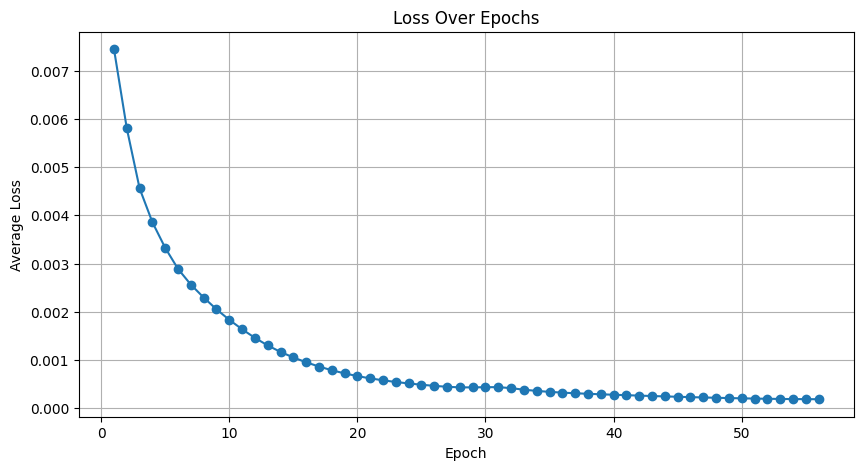

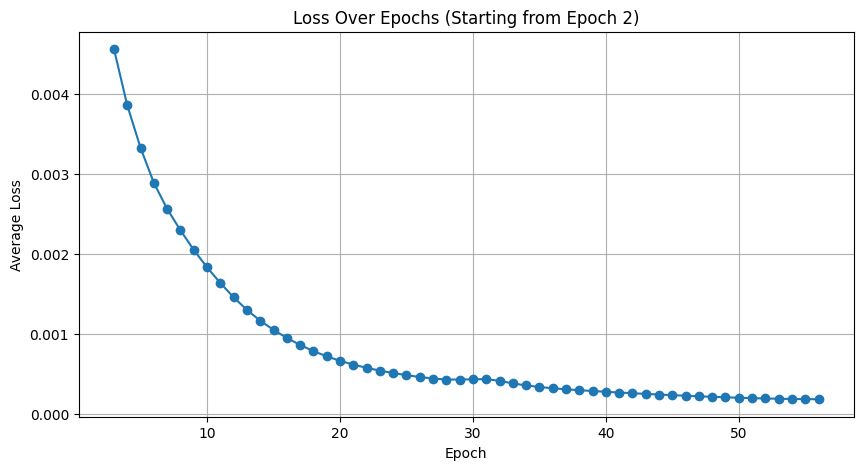

In [16]:
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(1, len(loss_history) + 1)
    plt.plot(epochs, loss_history, marker='o', linestyle='-')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

plot_loss(loss_history)
def plot_loss(loss_history):
    plt.figure(figsize=(10, 5))
    epochs = range(3, len(loss_history) + 1)  # 从第二轮开始绘制，所以范围从2开始
    plt.plot(epochs, loss_history[2:], marker='o', linestyle='-')  # 从第二轮开始绘制，所以从索引1开始
    plt.title('Loss Over Epochs (Starting from Epoch 2)')
    plt.xlabel('Epoch')
    plt.ylabel('Average Loss')
    plt.grid(True)
    plt.show()

# 调用修改后的函数以绘制损失图
plot_loss(loss_history)

In [17]:
# 保存模型参数
torch.save(model.state_dict(), '/data/disk4/output_stocks/jmchen/factors/ML/zj_model/21_4_400_0.01s.pth')


In [18]:

X_test=X[180:]
Y_test=Y[180:]
model = MyModelZJ(input_size, num_factors, num_stocks)
# 加载保存的模型参数
model.load_state_dict(torch.load('/data/disk4/output_stocks/jmchen/factors/ML/zj_model/21_4_400_0.01s.pth'))
# 设置模型为评估模式
model.eval()

with torch.no_grad():
    input_sample = X_test  # 获取单个样本并添加批次维度
    label_sample = Y_test
    # 使用模型进行推理并获取单个样本的预测输出（c值）
    factors = model(input_sample)
    c_value=factors.mean(dim=2)
    print(c_value.shape)
    print(label_sample.shape)
    c1=[]
    c2=[]
    for i in range(c_value.shape[0]): 
        cv=c_value[i].T
        corr1=[]
        corr2=[]

        # 创建遮罩以识别c_value和Y_test中的非NaN值
        mask_c = ~torch.isnan(cv)
        mask_y = ~torch.isnan(label_sample[i])
        
        # 组合这些遮罩以获取c_value和Y_test的共同遮罩
        mask = mask_c & mask_y
        
        # 将遮罩应用于张量
        c_value_filtered = cv[mask]
        Y_test_filtered = label_sample[i][mask]

    
        # 计算每个输入的均值
        mean_c = torch.mean(c_value_filtered)
        mean_y = torch.mean(Y_test_filtered)
        # print(mean_c,mean_y)
        # 计算皮尔逊相关系数的分子和分母
        numerator = torch.sum((c_value_filtered - mean_c) * (Y_test_filtered - mean_y))
        # print(numerator)
        denominator_c = torch.sqrt(torch.sum((c_value_filtered - mean_c)**2))
        denominator_y = torch.sqrt(torch.sum((Y_test_filtered - mean_y)**2))

        # 计算皮尔逊相关系数
        pearson_corr = numerator / (denominator_c * denominator_y)
        corr1.append(pearson_corr.item())
        # 计算秩次差值
        rank_X = torch.argsort(cv.reshape(-1))
        rank_Y = torch.argsort(label_sample[i].reshape(-1))
        differences = rank_X - rank_Y
        # 计算斯皮尔曼秩相关系数
        n = len(c_value[i])
        spearman_corr = 1 - (6 * torch.sum(differences**2)) / (n * (n**2 - 1))
        corr2.append(spearman_corr)

        c1.append(np.mean(corr1))
        c2.append(np.mean(corr2))
    c1=np.mean(c1)
    c2=np.mean(c2)
    print('Pearson:',c1)
    print('Spearman:',c2)


torch.Size([63, 4348])
torch.Size([63, 4348])
Pearson: 0.046514239707326016
Spearman: -0.000992458
